In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
from pipeline import Pipeline
pipeline = Pipeline()

/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/srikantamehta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing

In [2]:
# Function to print the chunks
def display_processed_chunks(processed_chunks, description):
    print(f"\n{description}:")
    for i, (chunk, embedding) in enumerate(processed_chunks[:5]):
        print(f"Index {i+1}, Chunk: {chunk}")
        print(f"Embedding (shape {embedding.shape}): {embedding[:5]}...") 
    print("\n" + "-"*40 + "\n")

# Test sentence-based chunking with overlap size 2
processed_chunks_2 = pipeline.preprocess_corpus("../storage/corpus", chunking_strategy='sentence', overlap_size=2)
display_processed_chunks(processed_chunks_2, "Sentence-based chunking with overlap 2")

# Test sentence-based chunking with overlap size 4
processed_chunks_4 = pipeline.preprocess_corpus("../storage/corpus", chunking_strategy='sentence', overlap_size=4)
display_processed_chunks(processed_chunks_4, "Sentence-based chunking with overlap 4")

# Test fixed-length chunking with different configurations
processed_fixed_50_3 = pipeline.preprocess_corpus("../storage/corpus", chunking_strategy='fixed-length', fixed_length=50, overlap_size=3)
display_processed_chunks(processed_fixed_50_3, "Fixed-length chunking (50 tokens) with overlap 3")

processed_fixed_100_2 = pipeline.preprocess_corpus("../storage/corpus", chunking_strategy='fixed-length', fixed_length=100, overlap_size=2)
display_processed_chunks(processed_fixed_100_2, "Fixed-length chunking (100 tokens) with overlap 2")

processed_fixed_150_1 = pipeline.preprocess_corpus("../storage/corpus", chunking_strategy='fixed-length', fixed_length=150, overlap_size=1)
display_processed_chunks(processed_fixed_150_1, "Fixed-length chunking (150 tokens) with overlap 1")



Sentence-based chunking with overlap 2:
Index 1, Chunk: Grover Cleveland Stephen Grover Cleveland (March 18 1837 June 24 1908), the twenty-second and twenty-fourth President of the United States, was the only President to serve non-consecutive terms (1885 1889 and 1893 1897). He was defeated for reelection in 1888 by Benjamin Harrison, against whom he ran again in 1892 and won a second term.
Embedding (shape (384,)): [ 0.03057819 -0.00119982  0.03321294 -0.02724342 -0.04510499]...
Index 2, Chunk: He was the only Democrat elected to the Presidency in the era of Republican political domination between 1860 and 1912, after the American Civil War. His admirers praise him for his bedrock honesty, independence, integrity, and commitment to the principles of classical liberalism.
Embedding (shape (384,)): [ 0.05279159 -0.01434088 -0.03437803 -0.04786543 -0.01323907]...
Index 3, Chunk: As a leader of the Bourbon Democrats, he opposed imperialism, taxes, corruption, patronage, subsidies and in

### Reranker Analysis

In [6]:
from modules.retrieval.reranker import Reranker
from modules.generator.question_answering import QA_Generator
from modules.metrics import Metrics_Automated
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and filter out rows with "NULL" or NaN answers
questions_df = pd.read_csv("../qa_resources/questions.csv", delimiter='\t')
questions_df = questions_df[questions_df['Answer'].notna() & (questions_df['Answer'] != "NULL")]

# Extract sample context from processed chunks
sample_context = [chunk[0] for chunk in processed_chunks_2]

# Filter for multiple samples from each difficulty level
easy_questions = questions_df[questions_df['DifficultyFromQuestioner'] == 'easy'].sample(3, random_state=1)
medium_questions = questions_df[questions_df['DifficultyFromQuestioner'] == 'medium'].sample(3, random_state=1)
hard_questions = questions_df[questions_df['DifficultyFromQuestioner'] == 'hard'].sample(3, random_state=1)
sample_questions = pd.concat([easy_questions, medium_questions, hard_questions])

# Fetch API key
api_key = os.getenv("MISTRAL_API_KEY")
qa_generator = QA_Generator(api_key=api_key)
metrics = Metrics_Automated(model="distilbert") 

# Function to analyze each re-ranking strategy
def analyze_reranking(query, answer, context, reranker_type, subset_size=10, tfidf_weight=0.3):
    reranker = Reranker(type=reranker_type)
    
    # Re-ranking method 
    if reranker_type == "cross_encoder":
        ranked_documents, ranked_indices, scores = reranker.cross_encoder_rerank(query, context)
    elif reranker_type == "tfidf":
        ranked_documents, ranked_indices, scores = reranker.tfidf_rerank(query, context)
    elif reranker_type == "hybrid":
        ranked_documents, ranked_indices, scores = reranker.hybrid_rerank(query, context, tfidf_weight=tfidf_weight)
    elif reranker_type == "sequential":
        ranked_documents, ranked_indices, scores = reranker.sequential_rerank(query, context, subset_size=subset_size)
    elif reranker_type == "tfidf_corpus":
        ranked_documents, ranked_indices, scores = reranker.tfidf_corpus_rerank(query, context)
    else:
        raise ValueError(f"Unknown re-ranking strategy: {reranker_type}")

    # Generate an answer using the top-ranked context
    top_context = ranked_documents[0]
    generated_answer = qa_generator.generate_answer(query, [top_context])

    # Evaluate the generated answer with Transformer Match
    tm_score, tm_result = metrics.transformer_match(generated_answer, answer, query)

    return {
        "Top_5_Scores": scores[:5], 
        "Top_5_Documents": [doc[:100] for doc in ranked_documents[:5]], 
        "Top_Context": top_context,
        "Generated_Answer": generated_answer,
        "True_Answer": answer,
        "Transformer_Match_Score": tm_score
    }

results_list = []

# For each sample question run analysis for each re-ranking strategy
for _, question_row in sample_questions.iterrows():
    query = question_row['Question']
    true_answer = question_row['Answer']
    difficulty = question_row['DifficultyFromQuestioner']
    
    # Re-ranking strategies
    strategies = ["cross_encoder", "tfidf", "hybrid", "sequential", "tfidf_corpus"]
    
    for strategy in strategies:
        result = analyze_reranking(query, true_answer, sample_context, strategy)
        result.update({
            "Question": query,
            "Difficulty": difficulty,
            "Strategy": strategy
        })
        results_list.append(result)

# Convert to DataFrame
comparison_df = pd.DataFrame(results_list)


Using device: cpu
[ChatCompletionChoice(index=0, message=AssistantMessage(content="Yes, the arrival of Louis Kossuth was another issue that presented itself during Fillmore's presidency.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
[ChatCompletionChoice(index=0, message=AssistantMessage(content="Yes, the arrival of Louis Kossuth was another issue that presented itself during Fillmore's presidency.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
[ChatCompletionChoice(index=0, message=AssistantMessage(content="Yes, the arrival of Louis Kossuth was another issue that presented itself during Fillmore's presidency.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
[ChatCompletionChoice(index=0, message=AssistantMessage(content="Yes, the arrival of Louis Kossuth (exiled leader of a failed Hungarian revolution) was another issue that presented itself during Fillmore's presidency.", tool_calls=None, prefix=False,

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


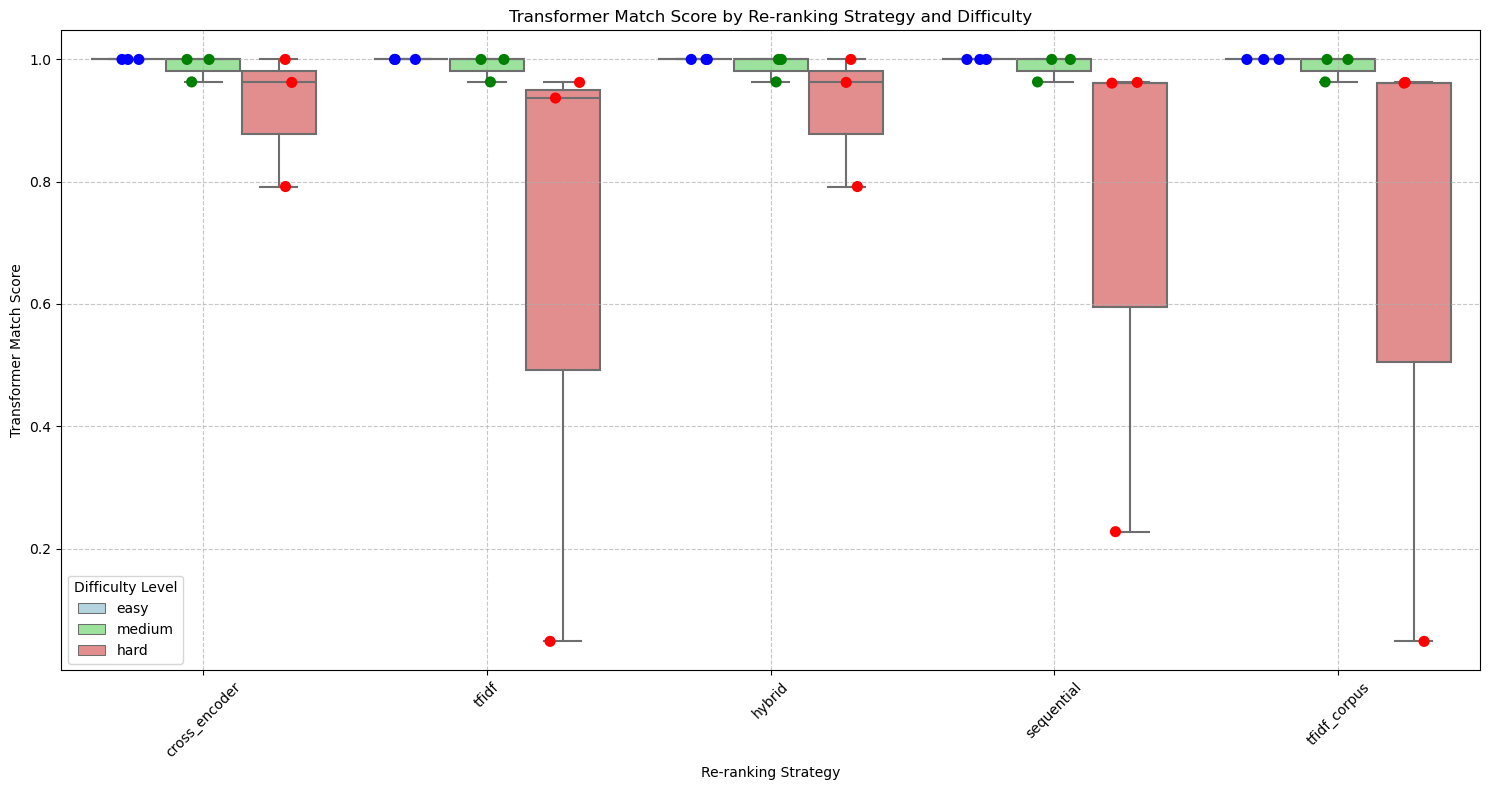

In [7]:
# Extract scores for plotting
def extract_score(score):
    try:
        if isinstance(score, dict):
            first_value = next(iter(score.values()))
            if isinstance(first_value, dict):
                return float(next(iter(first_value.values())))
            return float(first_value)
        return float(score)
    except (ValueError, TypeError) as e:
        print(f"Warning: Could not convert score {score}")
        return 0.0

comparison_df['Numeric_Score'] = comparison_df['Transformer_Match_Score'].apply(extract_score)

# Plotting the results
plt.figure(figsize=(15, 8))

sns.boxplot(
    data=comparison_df,
    x="Strategy",
    y="Numeric_Score",
    hue="Difficulty",
    palette={'easy': 'lightblue', 'medium': 'lightgreen', 'hard': 'lightcoral'},
    fliersize=0
)
sns.stripplot(
    data=comparison_df,
    x="Strategy",
    y="Numeric_Score",
    hue="Difficulty",
    dodge=True,
    jitter=0.2,
    marker='o',
    palette={'easy': 'blue', 'medium': 'green', 'hard': 'red'},
    size=8
)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:3], labels[:3], title="Difficulty Level")
plt.xlabel("Re-ranking Strategy")
plt.ylabel("Transformer Match Score")
plt.title("Transformer Match Score by Re-ranking Strategy and Difficulty")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Task 2: Analysis of Re-Ranking Strategies for the Case Study System

The boxplot visualizes the Transformer Match Score distribution across various re-ranking strategies—cross-encoder, TF-IDF, hybrid, sequential, and TF-IDF corpus—for three difficulty levels (easy, medium, and hard). This analysis visualizes each strategy's performance under different levels of question complexity and shows their respective strengths and weaknesses for our case study system.

## Strategy-Specific Analysis Based on Transformer Match Score

### Cross-Encoder Strategy
- **Performance**: The cross-encoder strategy shows consistently high scores across all question difficulties, achieving near-perfect accuracy for easy and medium questions, with only a slight dip for harder questions. This minimal variability reflects its reliability in selecting the most relevant context.
- **Use Case**: Given its high computational demand, the cross-encoder is better for contexts where accuracy is prioritized over efficiency. In our system, it could be employed for cases where precision is critical, such as processing high-priority or highly complex questions.

### TF-IDF Strategy
- **Performance**: While the TF-IDF strategy performs well for easy and medium questions, its effectiveness drops significantly with hard questions, as indicated by the greater variability and lower median scores. The strategy's simplicity limits its precision for complex queries.
- **Use Case**: The low computational cost of TF-IDF makes it ideal for handling high volumes of straightforward queries. For our case study system, it could be deployed as an initial retrieval layer for simpler or high-frequency questions, reserving more computationally intensive re-ranking methods for harder cases.

### Hybrid Strategy (Cross-Encoder + TF-IDF)
- **Performance**: The hybrid strategy, combining cross-encoder and TF-IDF, achieves a balance between accuracy and efficiency, showing strong and stable performance across all question levels. This strategy captures the strengths of both methods, maintaining accuracy with lower computational demands than the cross-encoder alone.
- **Use Case**: The hybrid strategy is versatile and well-suited for our system’s general purpose requirements. It could serve as the default re-ranking approach, handling diverse question difficulties without significant drops in performance. 

### Sequential Strategy (TF-IDF followed by Cross-Encoder)
- **Performance**: The sequential strategy, which first filters with TF-IDF and then re-ranks with a cross-encoder, performs well for easy and medium questions but exhibits increased variability for harder ones. Although it's computationally efficient, the initial TF-IDF step may occasionally exclude relevant contexts, leading to inconsistent results for challenging queries.
- **Use Case**: This strategy is valuable for situations where we need a compromise between speed and precision. In our system, it could be applied to medium-difficulty questions or for scenarios where computational resources are constrained but accuracy remains important.

### TF-IDF Corpus Strategy
- **Performance**: The TF-IDF corpus strategy operates similarly to the TF-IDF approach, offering reliable performance for easy questions but with significant variability and lower scores for hard questions.
- **Use Case**: The TF-IDF corpus approach is optimized for scenarios that require large-scale, low-latency processing, making it suitable for real-time applications within our system, such as initial filtering or other high-throughput modules. This strategy could benefit from an additional re-ranking phase for complex queries to enhance precision when needed.

## System Design Insights and Recommendations

### Strategy Selection Based on Question Complexity
- **Easy and Medium Questions**: For easy and medium questions, the TF-IDF and TF-IDF corpus strategies are efficient and yield high performance. These strategies could be used as a first-pass retrieval in our system to quickly handle simpler queries.
- **Hard Questions**: For hard questions, the cross-encoder and hybrid strategies stand out as the most effective choices. The hybrid strategy, offers a great balance of accuracy and efficiency, making it ideal for high-complexity questions.

The consistent performance of the hybrid strategy across all difficulty levels suggests it would be a good choice for our system’s default re-ranking strategy. T

### Adaptive Re-Ranking System Design
An adaptive system could dynamically select a re-ranking strategy based on question complexity. For instance:
- **Easy and Medium Questions**: Use TF-IDF or sequential strategies to reduce processing time.
- **Hard Questions**: Use cross-encoder or hybrid strategies to ensure accuracy.

This approach would allow our system to balance speed and accuracy efficiently, optimizing performance based on real-time query demands.

## Conclusion
In summary, each re-ranking strategy presents unique strengths. An adaptive system that dynamically employs these strategies based on question complexity would best serve our case study system, providing an optimized balance of computational efficiency and retrieval accuracy.
